In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pvlib.forecast import GFS, NAM, NDFD, HRRR, RAP
latitudeEsfahan, longitudeEsfahan, tzEsfahan = 32.65, 51.68, 'Etc/GMT+4'

# specify time range.
start = pd.Timestamp(datetime.date.today()-pd.Timedelta(days=1), tz=tzEsfahan)
end = start + pd.Timedelta(days=2)
#Diffuse Horizontal Irradiance (DHI), Global Horizontal Irradiance (GHI), Direct Normal Irradiance (DNI)
irrad_vars = ['ghi', 'dni', 'dhi']


In [20]:
# Global Forecast System
model = GFS()

# retrieve data. returns pandas.DataFrame object
rawWeatherDataEsfahan = model.get_data(latitudeEsfahan, longitudeEsfahan, start, end)
processedWeatherDataEsfahan = model.process_data(rawWeatherDataEsfahan)
interpolatedWeatherDataEsfahan = processedWeatherDataEsfahan.resample('5min').interpolate()



/var/folders/fv/rttqfl0j0fg3rpx88v9r4wb40000gp/T/ipykernel_85396/3904724779.py:2: pvlibDeprecationWarning: The GFS class was deprecated in pvlib 0.9.1 and will be removed in a future release. For details, see https://pvlib-python.readthedocs.io/en/stable/user_guide/forecasts.html
  model = GFS()


2022-07-09 00:00:00-04:00 2022-07-11 00:00:00-04:00


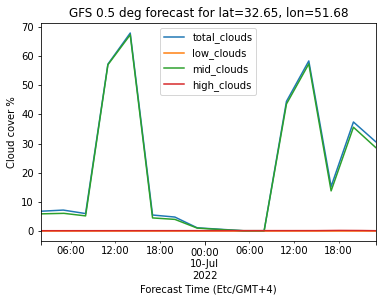

In [21]:
# plot cloud cover percentages
cloud_vars = ['total_clouds', 'low_clouds', 'mid_clouds', 'high_clouds']
interpolatedWeatherDataEsfahan[cloud_vars].plot()
plt.ylabel('Cloud cover %')
plt.xlabel('Forecast Time ({})'.format(tzEsfahan))
plt.title('GFS 0.5 deg forecast for lat={}, lon={}'.format(latitudeEsfahan, longitudeEsfahan))
plt.legend()
print(start, end)

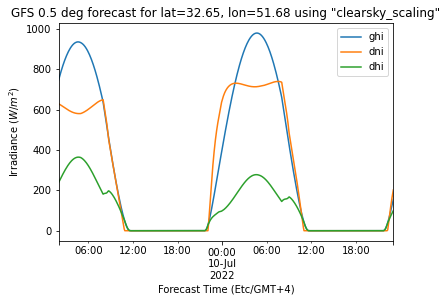

In [22]:
# plot irradiance data
irrads = model.cloud_cover_to_irradiance(interpolatedWeatherDataEsfahan['total_clouds'], how='clearsky_scaling')
irrads.plot()
plt.ylabel('Irradiance ($W/m^2$)')
plt.xlabel('Forecast Time ({})'.format(tzEsfahan))
plt.title('GFS 0.5 deg forecast for lat={}, lon={} using "clearsky_scaling"'.format(latitudeEsfahan, longitudeEsfahan));
plt.legend()

In [23]:
from pvlib.pvsystem import PVSystem, retrieve_sam
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.modelchain import ModelChain

sandia_modules = retrieve_sam('sandiamod')
cec_inverters = retrieve_sam('cecinverter')

module = sandia_modules['BP_Solar_BP3220N_Module___2010_'] #220W
myModule = module.copy()
#Values taken from retool panelPower
myModule["Voco"] = 36.5
myModule["Isco"] = 9.42 
myModule["Vmpo"] = 32.6
myModule["Impo"] = 8.42

inverter = cec_inverters['SMA_America__SC630CP_US__with_ABB_EcoDry_Ultra_transformer_']

temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']


system = PVSystem(surface_tilt=20, surface_azimuth=180, module_parameters=myModule, inverter_parameters=inverter, temperature_model_parameters=temperature_model_parameters, modules_per_string=25, strings_per_inverter=8)


fx_model = GFS()

fx_data = fx_model.get_processed_data(latitudeEsfahan, longitudeEsfahan, start, end)
fx_data = fx_data.resample('60min').interpolate()


mc = ModelChain(system, fx_model.location)


mc.run_model(fx_data);

/var/folders/fv/rttqfl0j0fg3rpx88v9r4wb40000gp/T/ipykernel_85396/4191896342.py:24: pvlibDeprecationWarning: The GFS class was deprecated in pvlib 0.9.1 and will be removed in a future release. For details, see https://pvlib-python.readthedocs.io/en/stable/user_guide/forecasts.html
  fx_model = GFS()


poa_global            286.304698
poa_direct             15.436088
poa_diffuse           271.151651
poa_sky_diffuse       268.963764
poa_ground_diffuse      2.187888
dtype: float64

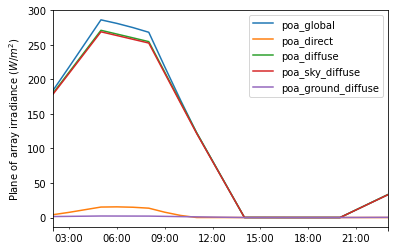

In [9]:
mc.results.total_irrad.plot()
plt.ylabel('Plane of array irradiance ($W/m^2$)')
plt.legend(loc='best')
mc.results.total_irrad.max()

2022-07-09 02:00:00-04:00    31267.864965
2022-07-09 03:00:00-04:00    35152.661362
2022-07-09 04:00:00-04:00    37037.249730
2022-07-09 05:00:00-04:00    37596.420454
2022-07-09 06:00:00-04:00    35498.782221
2022-07-09 07:00:00-04:00    31524.834093
2022-07-09 08:00:00-04:00    25411.197325
2022-07-09 09:00:00-04:00    12602.155899
2022-07-09 10:00:00-04:00     2789.179692
2022-07-09 11:00:00-04:00        0.000000
2022-07-09 12:00:00-04:00        0.000000
2022-07-09 13:00:00-04:00        0.000000
2022-07-09 14:00:00-04:00        0.000000
2022-07-09 15:00:00-04:00        0.000000
2022-07-09 16:00:00-04:00        0.000000
2022-07-09 17:00:00-04:00        0.000000
2022-07-09 18:00:00-04:00        0.000000
2022-07-09 19:00:00-04:00        0.000000
2022-07-09 20:00:00-04:00        0.000000
2022-07-09 21:00:00-04:00        0.000000
2022-07-09 22:00:00-04:00        0.000000
2022-07-09 23:00:00-04:00     2542.619685
2022-07-10 00:00:00-04:00    12189.533480
2022-07-10 01:00:00-04:00    22763

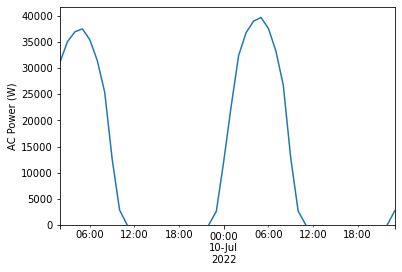

In [24]:
mc.results.ac[mc.results.ac <= 0] =  0
mc.results.ac.plot()
plt.ylim(0, None)
plt.ylabel('AC Power (W)')
print(mc.results.ac.fillna(0))

2022-07-09 02:00:00-04:00    31267.864965
2022-07-09 03:00:00-04:00    35152.661362
2022-07-09 04:00:00-04:00    37037.249730
2022-07-09 05:00:00-04:00    37596.420454
2022-07-09 06:00:00-04:00    35498.782221
2022-07-09 07:00:00-04:00    31524.834093
2022-07-09 08:00:00-04:00    25411.197325
2022-07-09 09:00:00-04:00    12602.155899
2022-07-09 10:00:00-04:00     2789.179692
2022-07-09 11:00:00-04:00        0.000000
2022-07-09 12:00:00-04:00             NaN
2022-07-09 13:00:00-04:00             NaN
2022-07-09 14:00:00-04:00             NaN
2022-07-09 15:00:00-04:00             NaN
2022-07-09 16:00:00-04:00             NaN
2022-07-09 17:00:00-04:00             NaN
2022-07-09 18:00:00-04:00             NaN
2022-07-09 19:00:00-04:00             NaN
2022-07-09 20:00:00-04:00             NaN
2022-07-09 21:00:00-04:00             NaN
2022-07-09 22:00:00-04:00        0.000000
2022-07-09 23:00:00-04:00     2542.619685
2022-07-10 00:00:00-04:00    12189.533480
2022-07-10 01:00:00-04:00    22763

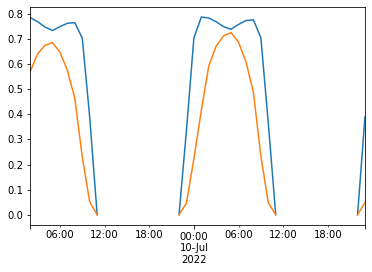

In [25]:
mc.results.ac[mc.results.ac <= 0] =  0
(mc.results.ac/200/274/mc.results.total_irrad["poa_global"]*1000).plot() 
(mc.results.ac/200/274).plot() 
#this should be written to the db as dimensionless number
#then multipled by the sum(panel mpp power) for each timestamp
#then sum(power*interval_duration) = total energy
print(mc.results.ac)

In [3]:
data = (mc.results.ac.fillna(0)/200/274)
data = list(zip(data,data.index))

In [4]:
import psycopg2
import psycopg2.extras
conn = psycopg2.connect(user="mjjyypvqfcescn", password="e93dc8ef167aa960b56248e5a2231cbc7d7ad5854266e7df2ab867763f065629", host="ec2-63-34-97-163.eu-west-1.compute.amazonaws.com",port="5432",database="d94t9tih4i30sp")
cur = conn.cursor()
query = """INSERT INTO production.power_forecast (power_factor, time_stamp) VALUES (%s, %s)
ON CONFLICT (time_stamp) DO UPDATE
SET power_factor = EXCLUDED.power_factor
"""
psycopg2.extras.execute_batch(cur, query, data)
conn.commit()
conn.close()
print("data uploaded to db")

data uploaded to db


In [191]:
money = sum(mc.results.ac.fillna(0)/200/274)*300*(.274*200)/3600*0.1  #infeed in USD
div = money/200/100
print(div*180)

0.16112919946540502
